In [1]:
import sys
import bitfinex
import datetime
import time
import pandas as pd
from operator import itemgetter
from functools import reduce
import copy
from pykalman import KalmanFilter
from math import sqrt
import statsmodels.api as sm

import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="hw")
import pyspark.sql.types as typ
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *
import pyspark.sql.functions as fn
import pyspark.mllib.stat as st
import numpy as np
import pyspark.mllib.linalg as ln

In [2]:
def fetch_data(start, stop, symbol, interval, tick_limit, step):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()
    data = []
    start = start - step
    while start < stop:
        start = start + step
        end = start + step
        res = api_v2.candles(symbol=symbol, interval=interval,limit=tick_limit, start=start, end=end)
        data.extend(res)
        time.sleep(2)
    return data


# Define query parameters
# Bitcoin, Etherium, Litecoin, Monero, Neo, Ripple, Zcash, OmiseGo, Stellar, Maker, Dai, EOSIO, Tron Protocol
pairs = ['ETHUSD', 'LTCUSD', 'XMRUSD', 'NEOUSD', 'XRPUSD', 'ZECUSD', 'BTCUSD']
bin_size = '30m' # This will return 60 minute data
limit = 1000    # We want the maximum of 1000 data points
# Define the start date
t_start = datetime.datetime(2019, 9, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000
# Define the end date
t_stop = datetime.datetime(2019, 9, 30, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

names = ['time', 'open', 'close', 'high', 'low', 'volume']

time_step = 1800000000
crypto_prices = [pd.DataFrame(fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=bin_size, tick_limit=limit, step=time_step), columns=names) for pair in pairs]

No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions
No keys, only access to public API functions


In [3]:
crypto_copy = copy.deepcopy(crypto_prices)

In [4]:
clean_df_list = []
#pairs = ['BTCUSD', 'ETHUSD', 'LTCUSD', 'XMRUSD', 'NEOUSD', 'XRPUSD', 'ZECUSD'] # Currency pair of interest
for pair, df in zip(pairs, crypto_copy):
    df.loc[:, 'time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    df = df.loc[:, ['close']]
    df = df.rename(columns={'close':pair})
    clean_df_list.append(df)

In [5]:
clean_df_list

[                          BTCUSD
 time                            
 2019-09-01 07:30:00  9635.800000
 2019-09-01 08:00:00  9609.000000
 2019-09-01 08:30:00  9617.300000
 2019-09-01 09:00:00  9600.000000
 2019-09-01 09:30:00  9627.500000
 ...                          ...
 2019-11-02 17:00:00  9376.745333
 2019-11-02 17:30:00  9332.700000
 2019-11-02 18:00:00  9330.000000
 2019-11-02 18:30:00  9330.300000
 2019-11-02 19:00:00  9348.100000
 
 [3000 rows x 1 columns],
                      ETHUSD
 time                       
 2019-09-01 07:30:00  172.71
 2019-09-01 08:00:00  170.80
 2019-09-01 08:30:00  170.86
 2019-09-01 09:00:00  170.55
 2019-09-01 09:30:00  171.01
 ...                     ...
 2019-11-02 17:00:00  185.85
 2019-11-02 17:30:00  184.79
 2019-11-02 18:00:00  185.08
 2019-11-02 18:30:00  184.82
 2019-11-02 19:00:00  184.64
 
 [3000 rows x 1 columns],
                      LTCUSD
 time                       
 2019-09-01 07:00:00  65.069
 2019-09-01 07:30:00  65.099
 2019-09-

In [6]:
combined_cryptos = reduce(lambda df1,df2: pd.merge(df1,df2,on='time'), clean_df_list)

In [7]:
combined_cryptos

,BTCUSD,ETHUSD,LTCUSD,XMRUSD,NEOUSD,XRPUSD,ZECUSD,OMGUSD,XLMUSD,MKRUSD,DAIUSD,EOSUSD,TRXUSD
time,,,,,,,,,,,,,
2019-09-01 10:00:00,9615.400000,170.820000,64.749,67.629,8.771700,0.25634,44.888,1.08160,0.061968,466.31,1.0072,3.282800,0.015414
2019-09-01 17:30:00,9617.220412,170.170000,64.931,67.813,8.781600,0.25460,44.923,1.07970,0.061635,463.01,1.0117,3.191100,0.015507
2019-09-01 21:30:00,9722.000000,171.426355,66.709,73.686,8.770000,0.25665,45.326,1.09540,0.062152,485.11,1.0132,3.253500,0.015614
2019-09-02 17:00:00,10108.450477,178.040000,66.437,72.819,9.071100,0.25935,46.527,1.09690,0.062810,485.11,1.0149,3.346200,0.015938
2019-09-02 20:30:00,10422.000000,180.280000,67.772,73.563,9.200000,0.26341,47.215,1.09890,0.063583,485.11,1.0120,3.354700,0.016000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01 13:00:00,9172.000000,181.100000,58.101,59.000,10.509000,0.29095,37.315,0.94196,0.069352,545.00,1.0116,3.275700,0.019480
2019-11-01 16:00:00,9193.500000,180.993582,57.730,60.260,10.559000,0.28961,37.400,0.94576,0.068961,533.24,1.0102,3.307500,0.019357
2019-11-01 16:30:00,9212.700000,181.082262,58.023,61.390,10.533000,0.29059,37.501,0.94580,0.069044,521.84,1.0101,3.312532,0.019414


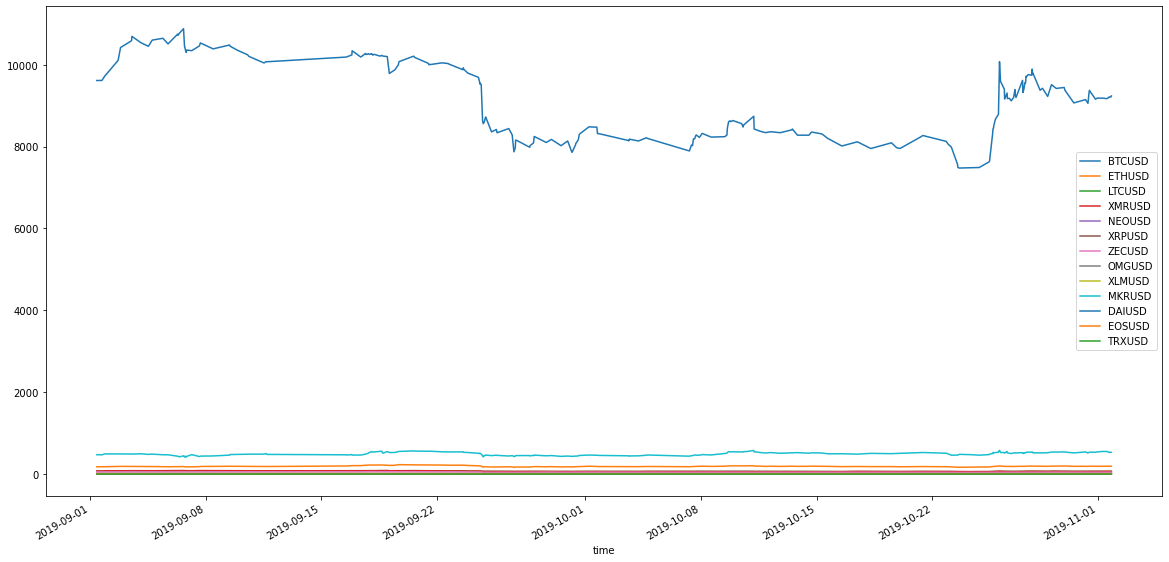

In [8]:
combined_cryptos.plot(figsize=(20,10));

In [9]:
import numpy as np
import statsmodels.api as sm
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

In [13]:
%%time
split = int(len(combined_cryptos) * .4)
pvalue_matrix,pairs = find_cointegrated_pairs(combined_cryptos.iloc[:split])
#convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

for pair in pairs:
    print("Stock {} and stock {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Stock ETHUSD and stock MKRUSD has a co-integration score of 0.015
Stock LTCUSD and stock ZECUSD has a co-integration score of 0.0004
Stock LTCUSD and stock OMGUSD has a co-integration score of 0.0412
Stock NEOUSD and stock ZECUSD has a co-integration score of 0.0015
Stock XRPUSD and stock TRXUSD has a co-integration score of 0.009
Stock ZECUSD and stock OMGUSD has a co-integration score of 0.0296
Stock DAIUSD and stock EOSUSD has a co-integration score of 0.0219
Stock DAIUSD and stock TRXUSD has a co-integration score of 0.0235
Wall time: 778 ms


In [12]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = 0,
                      initial_state_covariance = 1, observation_covariance = 1, transition_covariance = .01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [13]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    x = df[s1]
    y = df[s2]
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    # calculate half life
    halflife = half_life(df1['spread'])
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1.loc[df1['num units long'][0]] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1.loc[df1['num units short'][0]] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    ##############################################################
    try:
        #print(df1['port rets'].mean())
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR

In [14]:
results = []
for pair in pairs:
    rets, sharpe,  CAGR = backtest(combined_cryptos.iloc[split:],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    #rets.plot(figsize=(20,15),legend=True)

The pair ETHUSD and MKRUSD produced a Sharpe Ratio of 0.0 and a CAGR of nan
The pair LTCUSD and ZECUSD produced a Sharpe Ratio of 0.0 and a CAGR of nan
The pair LTCUSD and OMGUSD produced a Sharpe Ratio of 0.0 and a CAGR of nan
The pair NEOUSD and ZECUSD produced a Sharpe Ratio of 2.67 and a CAGR of nan
The pair XRPUSD and TRXUSD produced a Sharpe Ratio of -0.19 and a CAGR of nan
The pair ZECUSD and OMGUSD produced a Sharpe Ratio of 0.0 and a CAGR of nan
The pair DAIUSD and EOSUSD produced a Sharpe Ratio of 0.0 and a CAGR of nan
The pair DAIUSD and TRXUSD produced a Sharpe Ratio of -1.21 and a CAGR of nan
